# NLP Disasters Mini Project
**Course:** CSCA 5642
**Date:** Dec 2025

In [1]:
# Basic Libs
import pandas as pd
import numpy as np
import string, os, re
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Force CPU to avoid CUDA 12.0 errors with RTX 5090

# Plotting Libs
import seaborn as sns
import matplotlib.pyplot as plt

# NLP Libs
import nltk
# NLTK One-Time Downloads
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Embedding Libs
from gensim.models import Word2Vec, FastText

# Linear Model Libs
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

# Neural Network Libs
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


2025-12-07 19:35:19.969991: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 19:35:19.995539: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 19:35:20.467391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [16]:
import tensorflow as tf, sys
print("TF:", tf.__version__)
print("Python:", sys.version)

TF: 2.20.0
Python: 3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:25:55) [GCC 14.3.0]


## Data & Preprocessing

In [2]:
class DisasterData:
    def __init__(self, path: str):
        self.train_df = pd.read_csv(path + '/train.csv')
        self.train_df, self.val_df = train_test_split(self.train_df, test_size=0.2, random_state=11, stratify=self.train_df['target'])
        self.test_df = pd.read_csv(path + '/test.csv')

        self.submission = None # Reminder to do the submission file!
        self._lemmatizer = WordNetLemmatizer()

        self.train_df['cleaned_text'] = self.train_df['text'].apply(self._clean_text)
        self.val_df['cleaned_text'] = self.val_df['text'].apply(self._clean_text)
        self.test_df['cleaned_text'] = self.test_df['text'].apply(self._clean_text)

        self.X_train = self.train_df['cleaned_text']
        self.y_train = self.train_df['target']
        self.X_val = self.val_df['cleaned_text']
        self.y_val = self.val_df['target']
        self.X_test = self.test_df['cleaned_text']

        self.X_train_raw = self.train_df['text']
        self.X_val_raw = self.val_df['text']
        self.X_test_raw = self.test_df['text']

    # Clean text for NLP
    def _clean_text(self, text: str) -> str:
        # Basic cleaning
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Tokenize
        words = text.split()

        # Stopwords
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

        # POS tagging + Lemmatization (POS tagging is slow, leverages a tagging model)
        tagged_words = nltk.pos_tag(words)
        lemmatized_words = [self._lemmatizer.lemmatize(word, pos=self._get_wordnet_pos(tag)) for word, tag in tagged_words]

        return ' '.join(lemmatized_words)
    
    # Helper for POS tagging
    def _get_wordnet_pos(self, tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

In [3]:
disaster_data = DisasterData(path='data')
print('Training Data Shape:', disaster_data.train_df.shape)
print('Validation Data Shape:', disaster_data.val_df.shape)
print('Test Data Shape:', disaster_data.test_df.shape)

Training Data Shape: (6090, 6)
Validation Data Shape: (1523, 6)
Test Data Shape: (3263, 5)


In [4]:
# Most common words
word_counts = disaster_data.X_train.str.split().explode().value_counts()
print('Most Common Words:')
print(word_counts.head(20))

print('Least Common Words:')
print(word_counts.tail(20))

Most Common Words:
cleaned_text
get         322
like        310
fire        289
im          239
amp         229
go          220
u           194
new         188
via         173
one         161
say         158
dont        157
people      156
bomb        145
news        145
kill        141
video       140
make        138
disaster    134
2           132
Name: count, dtype: int64
Least Common Words:
cleaned_text
lopezandthelion     1
natsnation          1
brucewillis         1
preppers            1
forney              1
rembr               1
kaotixblaze         1
crave               1
alexeivolkov1       1
mcfaul              1
roskomnadzor        1
ridiculously        1
sfor                1
seismicresistant    1
devastationû       1
pandemic            1
mp3                 1
rar                 1
thereal             1
comin               1
Name: count, dtype: int64


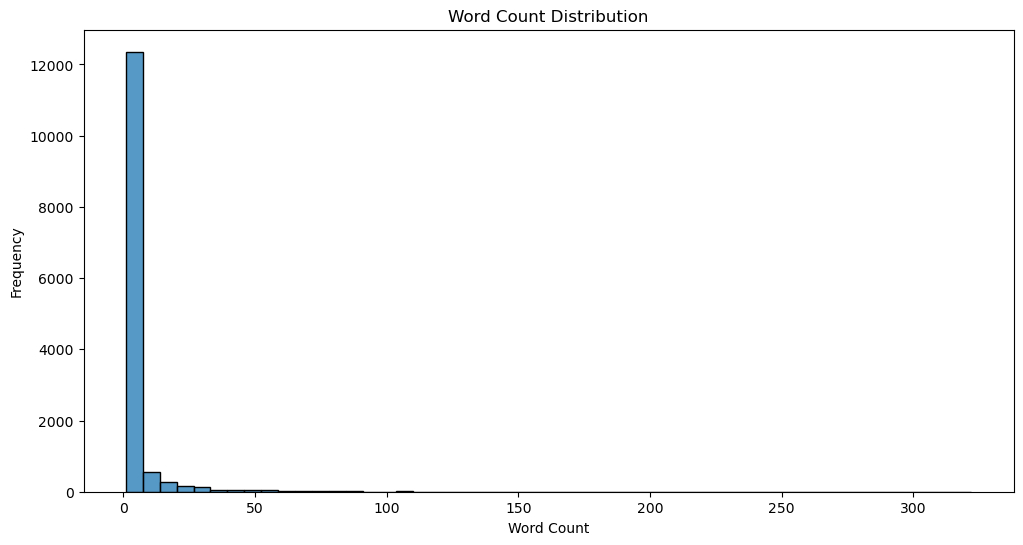

In [5]:
# Word count distribution
plt.figure(figsize=(12, 6))
sns.histplot(word_counts, bins=50, log_scale=False)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## TF-IDF Preprocessing + LogReg Baseline

In [6]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(disaster_data.X_train)
X_val_tfidf = tfidf.transform(disaster_data.X_val)
X_test_tfidf = tfidf.transform(disaster_data.X_test)

# Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(X_train_tfidf, disaster_data.y_train)

val_pred = log_reg.predict(X_val_tfidf)
val_f1 = f1_score(disaster_data.y_val, val_pred)
print(f'Baseline TF-IDF + LogReg F1 Score: {val_f1:.4f}')

Baseline TF-IDF + LogReg F1 Score: 0.7634


## RNN Model (Keras)

In [11]:
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(disaster_data.X_train)

X_train_seq = tokenizer.texts_to_sequences(disaster_data.X_train)
X_val_seq = tokenizer.texts_to_sequences(disaster_data.X_val)
X_test_seq = tokenizer.texts_to_sequences(disaster_data.X_test)

maxlen = 40

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

vocab_size = min(20000, len(tokenizer.word_index) + 1)
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()

/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train_pad, disaster_data.y_train,
    epochs=3,
    batch_size=64,
    validation_data=(X_val_pad, disaster_data.y_val),
    )

val_pred_prob = model.predict(X_val_pad).ravel()
val_pred = (val_pred_prob >= 0.5).astype(int)
val_f1_rnn = f1_score(disaster_data.y_val, val_pred)
print(f'LSTM F1 Score: {val_f1_rnn:.4f}')

Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5703 - loss: 0.6845 - val_accuracy: 0.5706 - val_loss: 0.6855
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6169 - loss: 0.6570 - val_accuracy: 0.7498 - val_loss: 0.5451
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6969 - loss: 0.5637 - val_accuracy: 0.5673 - val_loss: 0.6588
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM F1 Score: 0.6451


### Kaggle Submission

In [9]:
test_pred_prob = model.predict(X_test_pad).ravel()
test_pred = (test_pred_prob >= 0.5).astype(int)

disaster_data.submission = pd.DataFrame({
    'id': disaster_data.test_df.id,
    'target': test_pred
})
disaster_data.submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


## Error Analysis

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

mis_idx = np.where(val_pred != disaster_data.y_val)[0][:3]

for i in mis_idx:
    text_i = disaster_data.X_val_raw.iloc[i]
    vec_i = X_val_tfidf[i]

    # find nearest neighbors in training set
    sims = cosine_similarity(vec_i, X_train_tfidf).ravel()
    top_idx = sims.argsort()[-3:][::-1]

    print('--- Misclassified Text ---')
    print('Text:', text_i)
    print('Pred:', val_pred[i])
    print('True:', disaster_data.y_val.iloc[i])
    print('Nearest Neighbors:')
    for idx in top_idx:
        print(f'Text: {disaster_data.X_train_raw.iloc[idx]}')
    print()

--- Misclassified Text ---
Text: @Blizzard_draco @LoneWolffur I need this.
Pred: 1
True: 0
Nearest Neighbors:
Text: @Blizzard_draco @LoneWolffur also me please I would very much like a link
Text: @LoneWolffur control yourself tora
Text: @LoneWolffur BRUH *dies*

--- Misclassified Text ---
Text: #news Politifiact: Harry Reid's '30 Percent of Women Served' Planned Parenthood Claim Is a 'Pants on Fire' Lie... http://t.co/bMSeDZOfSV
Pred: 1
True: 0
Nearest Neighbors:
Text: Politifiact: Harry Reid's '30 Percent of Women Served' Planned Parenthood Claim Is a 'Pants on Fire' Lie http://t.co/aMYMwWcpYm | #tcot
Text: 30 seconds for my bitches to evacuate ??????
Text: @NoahCRothman Bore him with minutiae serve bad champagne. He may just explode.

--- Misclassified Text ---
Text: @mustachemurse @dateswhitecoats the truth. I pulled a 16 out. And apparently a 22 in the crazy adult trauma. And they mocked me for the 22.
Pred: 1
True: 0
Nearest Neighbors:
Text: SCREAMING IN 22 DIFFERENT LANGUAGES htt